## Setup imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from tensorflow.compiler.tf2xla.python import xla

## Load the dataset and visualize the data

11490434/11490434 [==============================] - 2s 0us/step
4 Random Training samples and labels


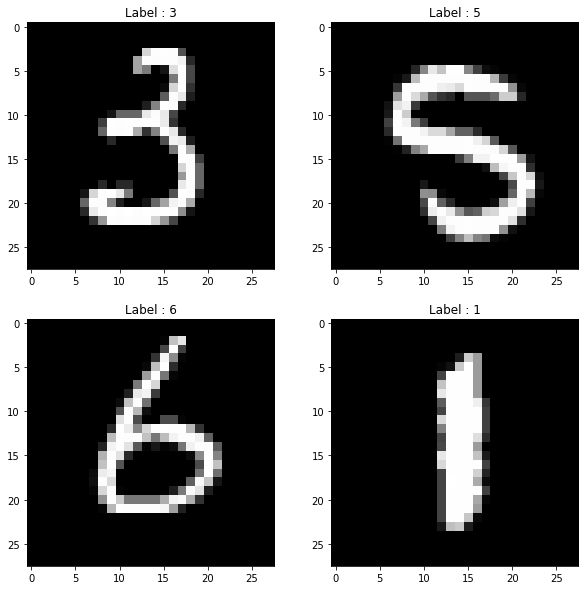

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("4 Random Training samples and labels")
idx1, idx2, idx3, idx4 = random.sample(range(0, x_train.shape[0]), 4)

img1 = (x_train[idx1], y_train[idx1])
img2 = (x_train[idx2], y_train[idx2])
img3 = (x_train[idx3], y_train[idx3])
img4 = (x_train[idx4], y_train[idx4])

imgs = [img1, img2, img3, img4]

plt.figure(figsize=(10, 10))

for idx, item in enumerate(imgs):
    image, label = item[0], item[1]
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label : {label}")
plt.show()

## Define `FFDense` custom layer

In [ ]:
class FFDense(keras.layers.Layer):
    """
    A Dense layer that has been custom-enabled for the Forward-Forward algorithm and includes an implementation of 
    the Forward-Forward network for use. To use this layer, it must be paired with the FFNetwork model.
    """

    def __init__(
        self,
        units,
        optimizer,
        loss_metric,
        num_epochs=50,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dense = keras.layers.Dense(
            units=units,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs

    # We perform a normalization step before we run the input through the Dense
    # layer.

    def call(self, x):
        x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
        x_norm = x_norm + 1e-4
        x_dir = x / x_norm
        res = self.dense(x_dir)
        return self.relu(res)

    '''
    The Forward-Forward algorithm is described below: First, we perform the operation of the Dense layer 
    and then calculate the Mean Square value for both positive and negative samples. 
    Our custom loss function calculates the distance between the Mean-squared result and a threshold value, 
    which we set as a hyperparameter to determine if the prediction is positive or negative. 
    After calculating the loss, we take the mean across the entire batch and perform a gradient calculation
    and optimization step. This is not considered traditional backpropagation, as no gradients are sent to
    previous layers and the process is completely localized.
    '''

    def forward_forward(self, x_pos, x_neg):
        for i in range(self.num_epochs):
            with tf.GradientTape() as tape:
                g_pos = tf.math.reduce_mean(tf.math.pow(self.call(x_pos), 2), 1)
                g_neg = tf.math.reduce_mean(tf.math.pow(self.call(x_neg), 2), 1)

                loss = tf.math.log(
                    1
                    + tf.math.exp(
                        tf.concat([-g_pos + self.threshold, g_neg - self.threshold], 0)
                    )
                )
                mean_loss = tf.cast(tf.math.reduce_mean(loss), tf.float32)
                self.loss_metric.update_state([mean_loss])
            gradients = tape.gradient(mean_loss, self.dense.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))
        return (
            tf.stop_gradient(self.call(x_pos)),
            tf.stop_gradient(self.call(x_neg)),
            self.loss_metric.result(),
        )


## Define the `FFNetwork` Custom Model

In [ ]:

class FFNetwork(keras.Model):
    """
    A keras.Model that enables creation of a FFDense network and can be used for any type of 
    classification task. This model includes an internal implementation tailored for the 
    MNIST dataset, which can be adapted to other use cases as needed.
    """
    '''
    Since each layer performs gradient calculation and optimization locally, each layer has its 
    own optimizer. The commonly used Adam optimizer is passed with a default learning rate of 
    0.03, which was determined to be the optimal rate after experimentation. The loss is 
    monitored using the loss_var and loss_count variables.
    '''
    def __init__(
        self, dims, layer_optimizer=keras.optimizers.Adam(learning_rate=0.03), **kwargs
    ):
        super().__init__(**kwargs)
        self.layer_optimizer = layer_optimizer
        self.loss_var = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.loss_count = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.layer_list = [keras.Input(shape=(dims[0],))]
        for d in range(len(dims) - 1):
            self.layer_list += [
                FFDense(
                    dims[d + 1],
                    optimizer=self.layer_optimizer,
                    loss_metric=keras.metrics.Mean(),
                )
            ]

    '''
    This function dynamically modifies the image by superimposing the labels on top of it 
    (for the MNIST dataset, which has 10 unique labels, the first 10 pixels in the top-left corner are used). 
    The function returns the original data tensor with the first 10 pixels representing the labels as a 
    pixel-based one-hot representation.
    '''

    @tf.function(reduce_retracing=True)
    def overlay_y_on_x(self, data):
        X_sample, y_sample = data
        max_sample = tf.reduce_max(X_sample, axis=0, keepdims=True)
        max_sample = tf.cast(max_sample, dtype=tf.float64)
        X_zeros = tf.zeros([10], dtype=tf.float64)
        X_update = xla.dynamic_update_slice(X_zeros, max_sample, [y_sample])
        X_sample = xla.dynamic_update_slice(X_sample, X_update, [0])
        return X_sample, y_sample

    """
    The custom function predict_one_sample makes predictions by passing images through the network, 
    evaluating the results generated by each layer (i.e. determining how high or low the output values 
    are relative to the set threshold for each label), and selecting the label with the highest values. 
    In this way, the images are evaluated for their "goodness" with all labels.
    """

    @tf.function(reduce_retracing=True)
    def predict_one_sample(self, x):
        goodness_per_label = []
        x = tf.reshape(x, [tf.shape(x)[0] * tf.shape(x)[1]])
        for label in range(10):
            h, label = self.overlay_y_on_x(data=(x, label))
            h = tf.reshape(h, [-1, tf.shape(h)[0]])
            goodness = []
            for layer_idx in range(1, len(self.layer_list)):
                layer = self.layer_list[layer_idx]
                h = layer(h)
                goodness += [tf.math.reduce_mean(tf.math.pow(h, 2), 1)]
            goodness_per_label += [
                tf.expand_dims(tf.reduce_sum(goodness, keepdims=True), 1)
            ]
        goodness_per_label = tf.concat(goodness_per_label, 1)
        return tf.cast(tf.argmax(goodness_per_label, 1), tf.float64)

    def predict(self, data):
        x = data
        preds = list()
        preds = tf.map_fn(fn=self.predict_one_sample, elems=x)
        return np.asarray(preds, dtype=int)

    """
    The custom train_step function replaces the internal train_step implementation.
     It takes all the input image tensors, flattens them, and creates positive and 
     negative samples of the images. A positive sample is an image with the correct 
     label overlayed on it using the overlay_y_on_x function, while a negative 
     sample is an image with a incorrect label. The samples are then passed through 
     each FFLayer and the Forward-Forward computation is performed. The final 
     loss value over all layers is returned as the loss.
    """

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        # Flatten op
        x = tf.reshape(x, [-1, tf.shape(x)[1] * tf.shape(x)[2]])

        x_pos, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, y))

        random_y = tf.random.shuffle(y)
        x_neg, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, random_y))

        h_pos, h_neg = x_pos, x_neg

        for idx, layer in enumerate(self.layers):
            if isinstance(layer, FFDense):
                print(f"Training layer {idx+1} now : ")
                h_pos, h_neg, loss = layer.forward_forward(h_pos, h_neg)
                self.loss_var.assign_add(loss)
                self.loss_count.assign_add(1.0)
            else:
                print(f"Passing layer {idx+1} now : ")
                x = layer(x)
        mean_res = tf.math.divide(self.loss_var, self.loss_count)
        return {"FinalLoss": mean_res}


## Convert MNIST `NumPy` arrays to `tf.data.Dataset`

In [ ]:
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(60000)
test_dataset = test_dataset.batch(10000)

## Fit the network and visualize results

In [ ]:
model = FFNetwork(dims=[784, 500, 500])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.03),
    loss="mse",
    jit_compile=True,
    metrics=['accuracy'],
)

epochs = 250
history = model.fit(train_dataset, epochs=epochs)

Epoch 1/250
Training layer 1 now : 
Training layer 2 now : 
Training layer 1 now : 
Training layer 2 now : 
1/1 [==============================] - 85s 85s/step - FinalLoss: 0.7278
Epoch 2/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.7079
Epoch 3/250
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.7026
Epoch 4/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6795
Epoch 5/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6559
Epoch 6/250
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.6335
Epoch 7/250
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.6135
Epoch 8/250
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.5961
Epoch 9/250
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.5806
Epoch 10/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5670
Epoch 11/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.554

## Perform inference and testing

Having trained the model to a large extent, we now see how it performs on the
test set. We calculate the Accuracy Score to understand the results closely.

Test Accuracy score : 97.77%


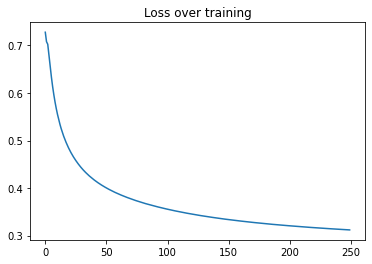

In [ ]:
preds = model.predict(tf.convert_to_tensor(x_test))

preds = preds.reshape((preds.shape[0], preds.shape[1]))

results = accuracy_score(preds, y_test)

print(f"Test Accuracy score : {results*100}%")

plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
plt.title("Loss over training")
plt.show()

## Conclusion

This example has hereby demonstrated how the Forward-Forward algorithm works using
the TensorFlow and Keras packages. While the investigation results presented by Prof. Hinton
in their paper are currently still limited to smaller models and datasets like MNIST and
Fashion-MNIST, subsequent results on larger models like LLMs are expected in future
papers.

Through the paper, Prof. Hinton has reported results of 1.36% test accuracy error with a
2000-units, 4 hidden-layer, fully-connected network run over 60 epochs (while mentioning
that backpropagation takes only 20 epochs to achieve similar performance). Another run of
doubling the learning rate and training for 40 epochs yields a slightly worse error rate
of 1.46%

The current example does not yield state-of-the-art results. But with proper tuning of
the Learning Rate, model architecture (number of units in `Dense` layers, kernel
activations, initializations, regularization etc.), the results can be improved
to match the claims of the paper.